In [161]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

# Dataset preparation

In [162]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahdimashayekhi/social-media-vs-productivity")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/social-media-vs-productivity


In [163]:
# Load dataset
df = pd.read_csv(path + '/social_media_vs_productivity.csv')

In [164]:
# Remove record with missing values

rows_with_missing = df[df.isnull().any(axis=1)]
print(f"Number of rows with missing values: {len(rows_with_missing)}")

df.dropna(inplace=True)

print("\nRemaining missing values:")
print(df.isnull().sum().sum())

Number of rows with missing values: 12926

Remaining missing values:
0


In [165]:
# Detect and remove outliers using IQR

# List of numeric columns
numeric_columns = [ 'age', 'stress_level', 'number_of_notifications',
        'work_hours_per_day', 'breaks_during_work', 'job_satisfaction_score',
        'coffee_consumption_per_day', 'days_feeling_burnout_per_month',
        'weekly_offline_hours', 'daily_social_media_time', 'screen_time_before_sleep',
        'perceived_productivity_score', 'actual_productivity_score', 'sleep_hours'
]

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # Remove outliers
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [166]:
# Remove redundant/uninformative variables

columns_to_remove = ['uses_focus_apps' , 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'perceived_productivity_score']
df.drop(columns=columns_to_remove, axis=1, inplace=True)


In [167]:
feature = ['job_satisfaction_score']
target = 'actual_productivity_score'

# DIY regression

In [168]:
# ---------- DIY Regression Core ----------
# Gradient Descent Function
def gradient_descent(X, y, learning_rate=0.01, n_iterations=1000):
    m, n = X.shape
    theta = np.random.randn(n)
    cost_history = []

    for _ in range(n_iterations):
        gradients = (2/m) * X.T.dot(X.dot(theta) - y)
        theta -= learning_rate * gradients
        cost = mean_squared_error(y, X.dot(theta))
        cost_history.append(cost)

    return theta, cost_history

# DIY regression with internal standardization and bias
def fit_diy_model(X_train, y_train, X_test):
    # Normalize training data
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std  # Use training stats

    # Add bias
    X_train_b = np.c_[np.ones((X_train_norm.shape[0], 1)), X_train_norm]
    X_test_b = np.c_[np.ones((X_test_norm.shape[0], 1)), X_test_norm]

    theta, _ = gradient_descent(X_train_b, y_train)
    y_pred = X_test_b.dot(theta)

    return y_pred

# Manual K-Fold for DIY regression
def cross_val_diy(X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    r2_scores = []
    mse_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        y_pred = fit_diy_model(X_train, y_train, X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        mse_scores.append(mean_squared_error(y_test, y_pred))

    return {
        "r2_mean": np.mean(r2_scores),
        "r2_std": np.std(r2_scores),
        "mse_mean": np.mean(mse_scores),
        "mse_std": np.std(mse_scores)
    }

# ---------- Evaluation ----------
def evaluate_models(X_sets, y, k=5):
    results = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for name, X in X_sets.items():
        X_np = X.to_numpy() if hasattr(X, 'to_numpy') else X
        y_np = y.to_numpy() if hasattr(y, 'to_numpy') else y

        # Sklearn
        model = LinearRegression()
        sk_r2 = cross_val_score(model, X_np, y_np, cv=kf, scoring='r2')
        sk_mse = -1 * cross_val_score(model, X_np, y_np, cv=kf, scoring='neg_mean_squared_error')


        # DIY
        diy_metrics = cross_val_diy(X_np, y_np, k)

        results.append({
            "Feature Set": name,

            # Sklearn
            "Sklearn R² Mean": np.mean(sk_r2),
            "Sklearn R² Std": np.std(sk_r2),
            "Sklearn MSE Mean": np.mean(sk_mse),
            "Sklearn MSE Std": np.std(sk_mse),

            # DIY
            "DIY R² Mean": diy_metrics["r2_mean"],
            "DIY R² Std": diy_metrics["r2_std"],
            "DIY MSE Mean": diy_metrics["mse_mean"],
            "DIY MSE Std": diy_metrics["mse_std"],
        })

    return results

# ---------- Plotting ----------
def plot_results(results):
    labels = [r['Feature Set'] for r in results]
    x = np.arange(len(labels))
    width = 0.35

    # R² comparison
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    sk_r2 = [r['Sklearn R² Mean'] for r in results]
    sk_r2_std = [r['Sklearn R² Std'] for r in results]
    diy_r2 = [r['DIY R² Mean'] for r in results]
    diy_r2_std = [r['DIY R² Std'] for r in results]

    ax[0].bar(x - width/2, sk_r2, width, yerr=sk_r2_std, label='Sklearn', color='#e096b1', capsize=5)
    ax[0].bar(x + width/2, diy_r2, width, yerr=diy_r2_std, label='DIY', color='#a3174a', capsize=5)
    ax[0].set_title("R² Score Comparison")
    ax[0].set_ylabel("R² Score")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels)
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.6)

    # MSE comparison
    sk_mse = [r['Sklearn MSE Mean'] for r in results]
    sk_mse_std = [r['Sklearn MSE Std'] for r in results]
    diy_mse = [r['DIY MSE Mean'] for r in results]
    diy_mse_std = [r['DIY MSE Std'] for r in results]

    ax[1].bar(x - width/2, sk_mse, width, yerr=sk_mse_std, label='Sklearn', color='#e096b1', capsize=5)
    ax[1].bar(x + width/2, diy_mse, width, yerr=diy_mse_std, label='DIY', color='#a3174a', capsize=5)
    ax[1].set_title("MSE Comparison")
    ax[1].set_ylabel("Mean Squared Error")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels)
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


def render_comparison_scatter_multifeature(X, y, feature_set_name):
    # Ensure NumPy format
    X_np = X.to_numpy() if hasattr(X, 'to_numpy') else X
    y_np = y.to_numpy() if hasattr(y, 'to_numpy') else y

    # --- DIY prediction ---
    y_pred_diy = fit_diy_model(X_np, y_np, X_np)

    # --- Sklearn prediction ---
    model = LinearRegression()
    model.fit(X_np, y_np)
    y_pred_sk = model.predict(X_np)

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.scatter(y_np, y_pred_diy, alpha=0.4, label="DIY Predictions", color="blue")
    plt.scatter(y_np, y_pred_sk, alpha=0.4, label="Sklearn Predictions", color="red")

    # Perfect prediction line
    min_val = min(y_np.min(), y_pred_diy.min(), y_pred_sk.min())
    max_val = max(y_np.max(), y_pred_diy.max(), y_pred_sk.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')

    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted: {feature_set_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

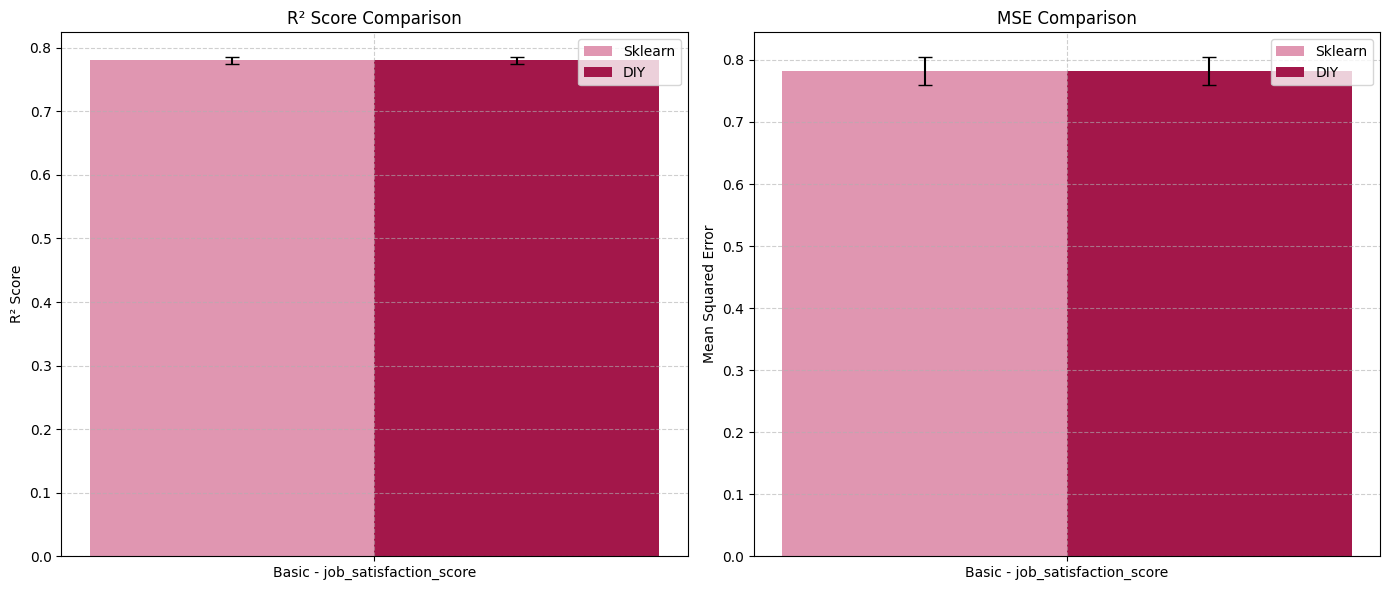

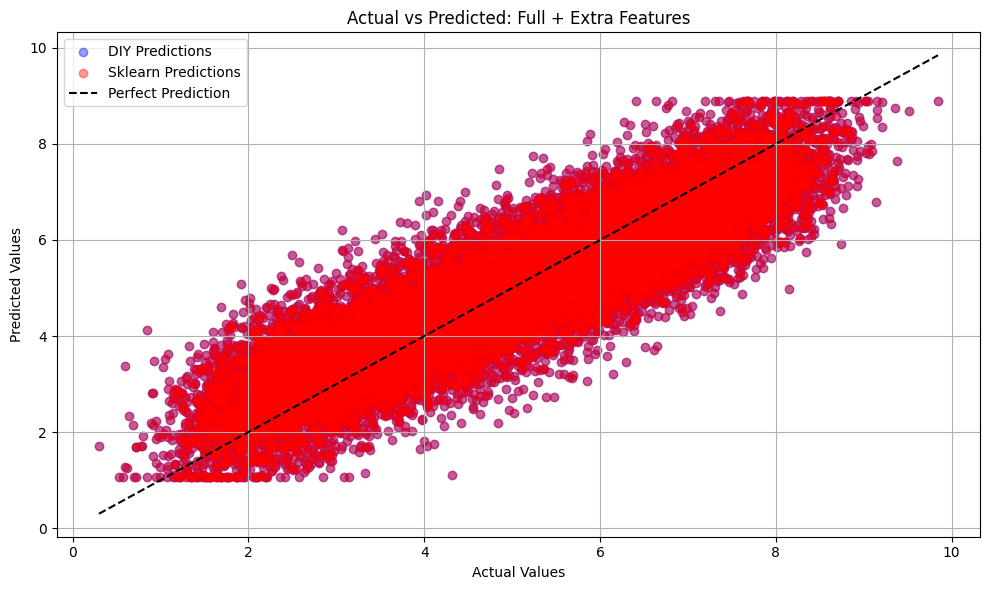


Feature Set: Basic - job_satisfaction_score
  Sklearn:  R² = 0.7803 ± 0.0049,  MSE = 0.7823 ± 0.0221
  DIY:      R² = 0.7803 ± 0.0049,  MSE = 0.7823 ± 0.0221


In [169]:
feature = ['job_satisfaction_score']
X = df[feature]
y = df[target]

X_sets = {
    "Basic - job_satisfaction_score": X
}

results = evaluate_models(X_sets, y)
plot_results(results)

render_comparison_scatter_multifeature(
    X_sets["Basic - job_satisfaction_score"],
    y,
    feature_set_name="Full + Extra Features"
)

for r in results:
    print(f"\nFeature Set: {r['Feature Set']}")
    print(f"  Sklearn:  R² = {r['Sklearn R² Mean']:.4f} ± {r['Sklearn R² Std']:.4f},  MSE = {r['Sklearn MSE Mean']:.4f} ± {r['Sklearn MSE Std']:.4f}")
    print(f"  DIY:      R² = {r['DIY R² Mean']:.4f} ± {r['DIY R² Std']:.4f},  MSE = {r['DIY MSE Mean']:.4f} ± {r['DIY MSE Std']:.4f}")

# Feature selection/engineering

In [170]:
df['satisfaction_burnout_ratio'] = df['job_satisfaction_score'] / (df['days_feeling_burnout_per_month'] + 1)
df['satisfaction_stress_ratio'] = df['job_satisfaction_score'] / (df['stress_level'] + 1)
df['satisfaction_sleep_adjusted'] = df['job_satisfaction_score'] * (df['sleep_hours'] / 8)
df['satisfaction_social_penalty'] = df['job_satisfaction_score'] / (df['daily_social_media_time'] + 1)
df['satisfaction_notification_ratio'] = df['job_satisfaction_score'] / (df['number_of_notifications'] + 1)
df['satisfaction_offline_interaction'] = df['job_satisfaction_score'] * df['weekly_offline_hours']

In [171]:
# Calculate correlation between all features and target
correlations = df.corr(numeric_only=True)['actual_productivity_score'].sort_values(ascending=False)

# Display correlations (excluding target itself)
print(correlations)

actual_productivity_score           1.000000
job_satisfaction_score              0.883428
satisfaction_notification_ratio     0.840784
satisfaction_sleep_adjusted         0.765407
satisfaction_stress_ratio           0.484089
satisfaction_social_penalty         0.448968
satisfaction_offline_interaction    0.428906
satisfaction_burnout_ratio          0.229870
age                                 0.013016
number_of_notifications             0.002978
breaks_during_work                  0.002874
screen_time_before_sleep            0.002390
stress_level                       -0.002510
work_hours_per_day                 -0.007690
sleep_hours                        -0.009279
daily_social_media_time            -0.012571
weekly_offline_hours               -0.012660
days_feeling_burnout_per_month     -0.013601
Name: actual_productivity_score, dtype: float64


In [172]:
features_1 = ['job_satisfaction_score']
features_2 = ['satisfaction_stress_ratio', 'satisfaction_sleep_adjusted']
features_3 = ['satisfaction_burnout_ratio', 'satisfaction_notification_ratio', 'stress_level']
features_4 = features_1 + features_2 + features_3

# Prepare data split
X1 = df[features_1]
X2 = df[features_2]
X3 = df[features_3]
X4 = df[features_4]
y = df[target]

# Preprocessing pipelines

# Feature Set 2
numeric_features_2 = X2.select_dtypes(include=['float64', 'int64']).columns.tolist()
preprocessor_2 = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_2)
])
X2_transformed = preprocessor_2.fit_transform(X2)

# Feature Set 3
numeric_features_3 = X3.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor_3 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features_3)
])

X3_transformed = preprocessor_3.fit_transform(X3)

# Feature Set 4
numeric_features_4 = X4.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor_4 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features_4)
])

X4_transformed = preprocessor_4.fit_transform(X4)

# Model evaluation & selection

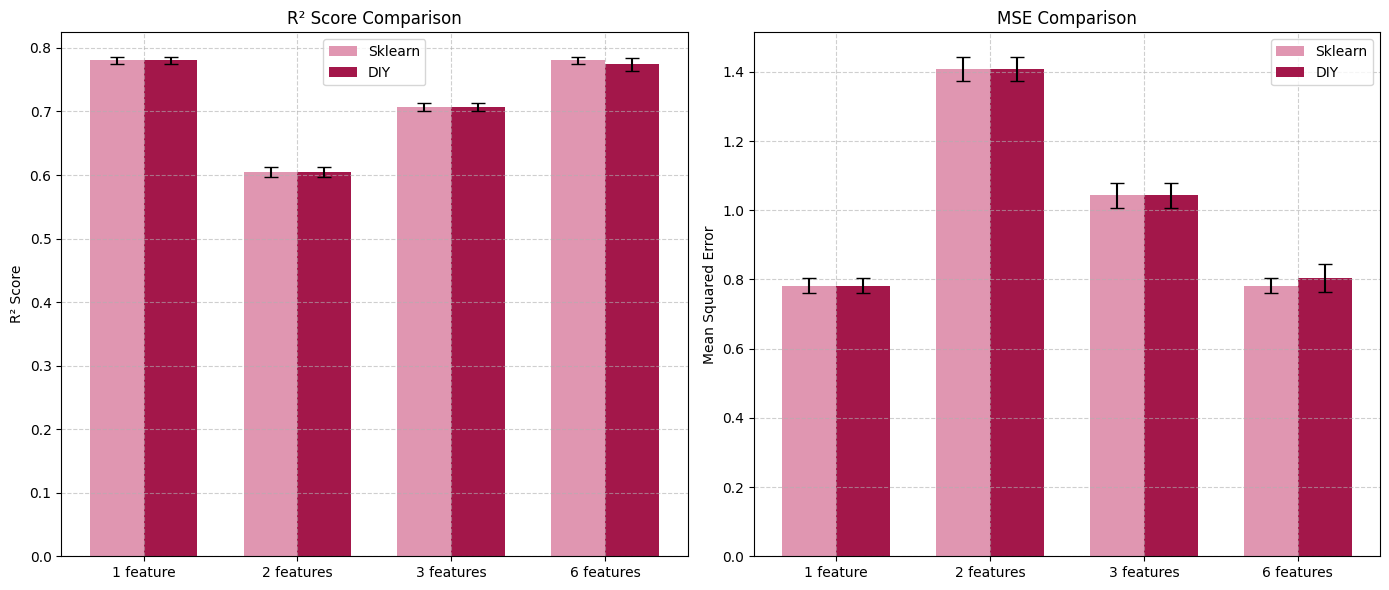


Feature Set: 1 feature
  Sklearn:  R² = 0.7803 ± 0.0049,  MSE = 0.7823 ± 0.0221
  DIY:      R² = 0.7803 ± 0.0049,  MSE = 0.7823 ± 0.0221

Feature Set: 2 features
  Sklearn:  R² = 0.6048 ± 0.0074,  MSE = 1.4074 ± 0.0347
  DIY:      R² = 0.6048 ± 0.0074,  MSE = 1.4074 ± 0.0347

Feature Set: 3 features
  Sklearn:  R² = 0.7072 ± 0.0066,  MSE = 1.0429 ± 0.0355
  DIY:      R² = 0.7072 ± 0.0066,  MSE = 1.0429 ± 0.0355

Feature Set: 6 features
  Sklearn:  R² = 0.7802 ± 0.0049,  MSE = 0.7825 ± 0.0221
  DIY:      R² = 0.7740 ± 0.0097,  MSE = 0.8049 ± 0.0402




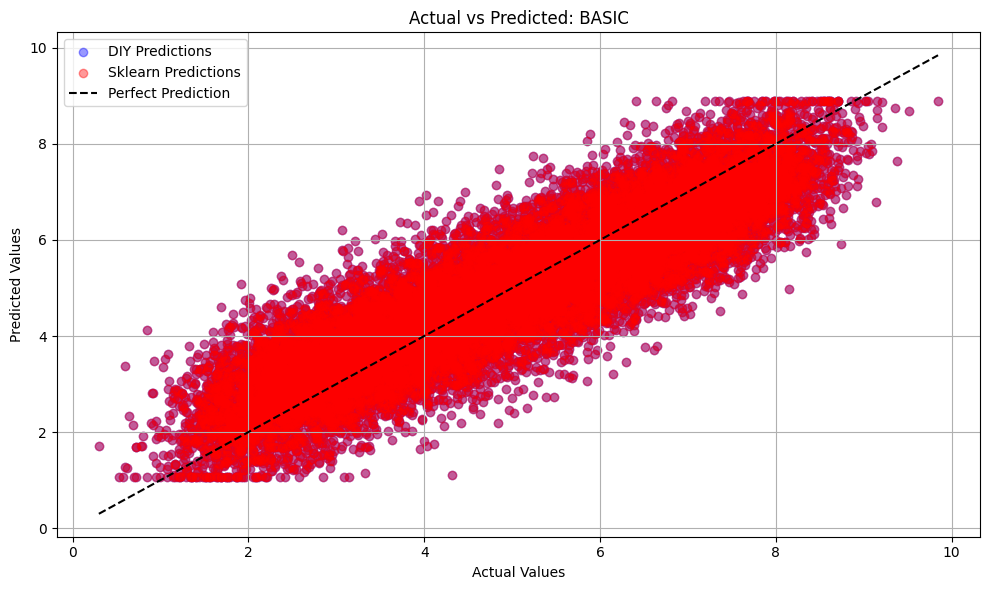

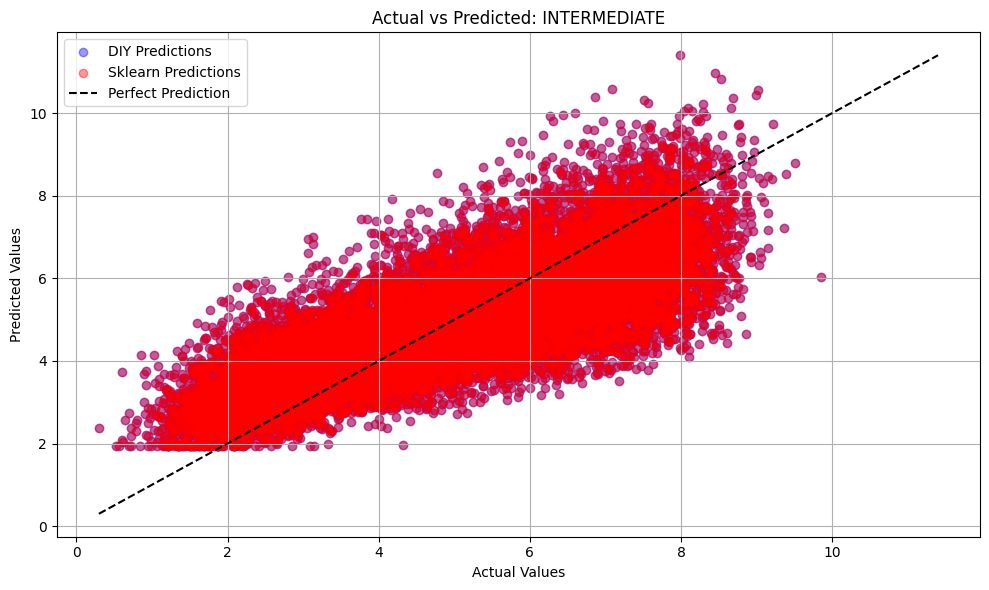

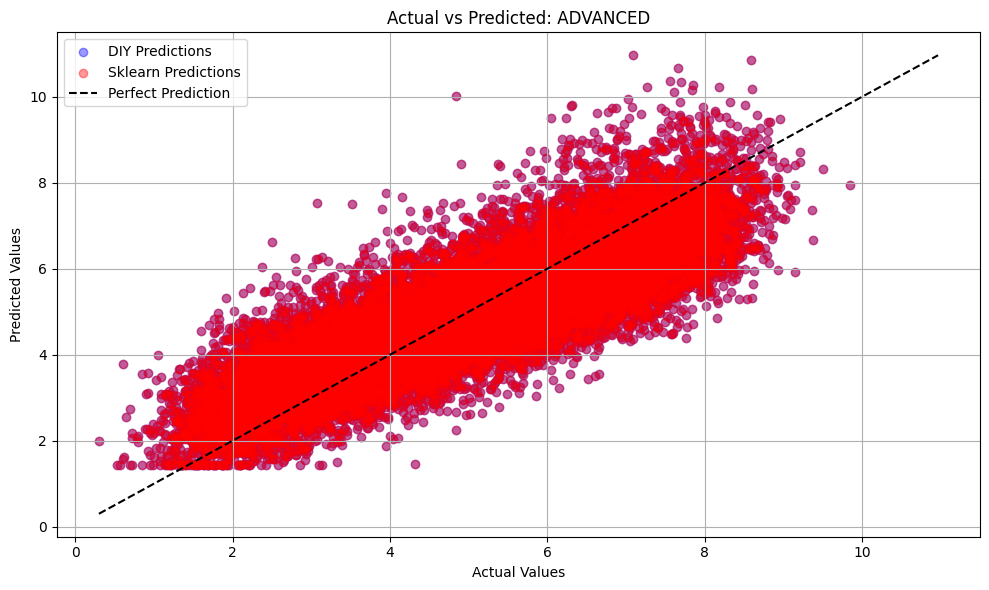

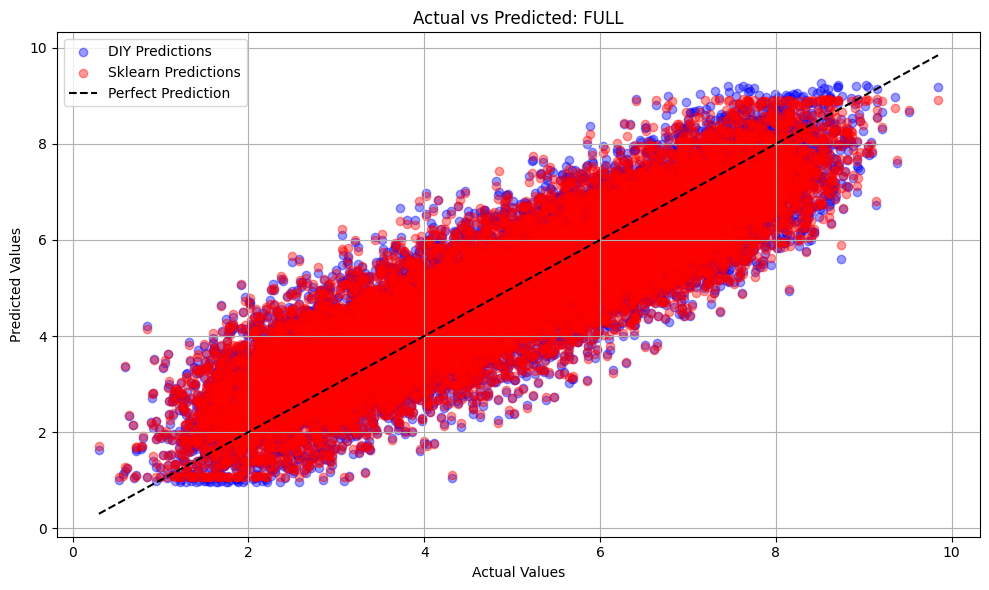

In [173]:
X_sets = {
    "1 feature": X1,
    "2 features": X2_transformed,
    "3 features": X3_transformed,
    "6 features": X4_transformed
}

results = evaluate_models(X_sets, y)
plot_results(results)

for r in results:
    print(f"\nFeature Set: {r['Feature Set']}")
    print(f"  Sklearn:  R² = {r['Sklearn R² Mean']:.4f} ± {r['Sklearn R² Std']:.4f},  MSE = {r['Sklearn MSE Mean']:.4f} ± {r['Sklearn MSE Std']:.4f}")
    print(f"  DIY:      R² = {r['DIY R² Mean']:.4f} ± {r['DIY R² Std']:.4f},  MSE = {r['DIY MSE Mean']:.4f} ± {r['DIY MSE Std']:.4f}")

print('\n')

render_comparison_scatter_multifeature(
    X_sets["1 feature"],
    y,
    feature_set_name="BASIC"
)

render_comparison_scatter_multifeature(
    X_sets["2 features"],
    y,
    feature_set_name="INTERMEDIATE"
)

render_comparison_scatter_multifeature(
    X_sets["3 features"],
    y,
    feature_set_name="ADVANCED"
)

render_comparison_scatter_multifeature(
    X_sets["6 features"],
    y,
    feature_set_name="FULL"
)